# Pretrained General 5 Layer CNN with Keras

In [1]:
import os
import re
import sys
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from six.moves import cPickle

from sklearn.metrics import classification_report
import time

## Theano
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
from theano.tensor.signal.pool import pool_2d

## Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.layers import Dropout, Flatten, Merge
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform, he_uniform
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, Callback

from collections import OrderedDict
import conv_net_helper as helper

import pydot
import h5py

print("- Device:", theano.config.device)
print("- Float", theano.config.floatX)
print("- System Version:", sys.version)
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
hello = tf.constant("Hello, TensorFlow!")
print(sess.run(hello))

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

/home/ec2-user/anaconda3/lib/python3.6/site-packages/theano/sandbox/cuda/__init__.py:556: UserWarning: Theano flag device=gpu* (old gpu back-end) only support floatX=float32. You have floatX=float64. Use the new gpu back-end with device=cuda* for that value of floatX.
  warnings.warn(msg)
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)
Using TensorFlow backend.


- Device: gpu
- Float float64
- System Version: 3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
b'Hello, TensorFlow!'


/home/ec2-user/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
X, Y = helper.load2d()
train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,Y)

Loading data...
Loading data Done


In [3]:
train_data.shape

(1712, 1, 96, 96)

In [7]:
def plot_model_performance(data):
    plt.plot(data.history['loss'], linewidth=3, label='train')
    plt.plot(data.history['val_loss'], linewidth=3, label='validation')
    plt.grid()
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.ylim(1e-4, 1e-2)
    plt.yscale('log')
    plt.show()

In [8]:
def execute_pretrain_model(epochs, train_data, train_labels, dev_data, dev_labels):
    start = 0.03
    stop = 0.001
    batch_size = 128
    
    #X, y = helper.load2d()
    #train_data, dev_data, train_labels, dev_labels = helper.get_split_data(X,y)
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='valid', activation='relu', data_format = 'channels_first', input_shape=(1,96, 96)))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.1)))  

    model.add(Conv2D(64, (2, 2), padding='valid', activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.2))) 

    model.add(Conv2D(128, (2, 2), padding='valid', activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.3)))  
    
    model.add(Conv2D(256, (2, 2), padding='valid', activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.3))) 
    
    model.add(Conv2D(512, (2, 2), padding='valid', activation='relu',data_format = 'channels_first'))
    model.add(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first'))
    model.add(Dropout(np.cast['float32'](0.3)))

    model.add(Flatten())
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(np.cast['float32'](0.4))) 
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(np.cast['float32'](0.4))) 
    model.add(Dense(600, activation='relu'))
    model.add(Dropout(np.cast['float32'](0.4))) 
    model.add(Dense(600, activation='relu'))
    model.add(Dense(30))

    sgd = SGD(lr=np.cast['float32'](0.01) , momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    
    early_stop = EarlyStopping(patience=100)
    learning_rates = np.linspace(start, stop, epochs)
    change_lr = LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))
    
    data =  model.fit(train_data, train_labels, 
                       batch_size = batch_size,
                       epochs=epochs, 
                       validation_data=(dev_data, dev_labels),
                       callbacks=[change_lr, early_stop])
    
    
    plot_model_performance(data)
    #helper.get_error(model,dev_data, dev_labels)
    #helper.save_model(model,"pretrain_model")
    return model

Train on 1712 samples, validate on 428 samples
Epoch 1/500
1712/1712 [==============================] - 74s - loss: 0.1155 - val_loss: 0.0660
Epoch 2/500
1712/1712 [==============================] - 74s - loss: 0.0224 - val_loss: 0.0232
Epoch 3/500
1712/1712 [==============================] - 74s - loss: 0.0086 - val_loss: 0.0141
Epoch 4/500
1712/1712 [==============================] - 74s - loss: 0.0068 - val_loss: 0.0104
Epoch 5/500
1712/1712 [==============================] - 74s - loss: 0.0061 - val_loss: 0.0084
Epoch 6/500
1712/1712 [==============================] - 74s - loss: 0.0057 - val_loss: 0.0072
Epoch 7/500
1712/1712 [==============================] - 74s - loss: 0.0056 - val_loss: 0.0065
Epoch 8/500
1712/1712 [==============================] - 74s - loss: 0.0054 - val_loss: 0.0060
Epoch 9/500
1712/1712 [==============================] - 74s - loss: 0.0053 - val_loss: 0.0055
Epoch 10/500
1712/1712 [==============================] - 74s - loss: 0.0052 - val_loss: 0.0052
Ep

1712/1712 [==============================] - 74s - loss: 0.0045 - val_loss: 0.0043
Epoch 170/500
1712/1712 [==============================] - 74s - loss: 0.0045 - val_loss: 0.0043
Epoch 171/500
1712/1712 [==============================] - 74s - loss: 0.0045 - val_loss: 0.0043
Epoch 172/500
1712/1712 [==============================] - 79s - loss: 0.0045 - val_loss: 0.0043
Epoch 173/500
1712/1712 [==============================] - 77s - loss: 0.0045 - val_loss: 0.0043
Epoch 174/500
1712/1712 [==============================] - 78s - loss: 0.0045 - val_loss: 0.0043
Epoch 175/500
1712/1712 [==============================] - 143s - loss: 0.0045 - val_loss: 0.0043
Epoch 176/500
1712/1712 [==============================] - 142s - loss: 0.0045 - val_loss: 0.0043
Epoch 177/500
1712/1712 [==============================] - 142s - loss: 0.0045 - val_loss: 0.0043
Epoch 178/500
1712/1712 [==============================] - 144s - loss: 0.0045 - val_loss: 0.0043
Epoch 179/500
1712/1712 [===============

1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 336/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 337/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 338/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 339/500
1712/1712 [==============================] - 143s - loss: 0.0044 - val_loss: 0.0043
Epoch 340/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 341/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 342/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 343/500
1712/1712 [==============================] - 142s - loss: 0.0044 - val_loss: 0.0043
Epoch 344/500
1712/1712 [==============================] - 144s - loss: 0.0044 - val_loss: 0.0043
Epoch 345/500
1712/1712 [=========

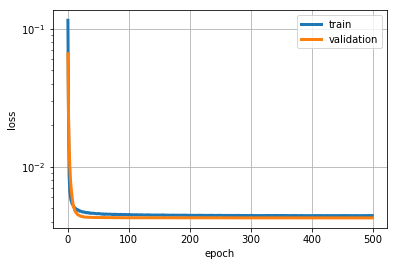

In [9]:
model = execute_pretrain_model(500, train_data, train_labels, dev_data, dev_labels)

In [10]:
def save_model(model, name):
    json_string = model.to_json()
    architecture = name+'_architecture.json' 
    weights = name+'_weights.h5'
    open(architecture, 'w').write(json_string)
    model.save_weights(weights)
    
save_model(model,"Pretrain_Model_Try")